## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [19]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
from sklearn.linear_model import LogisticRegression

In [20]:
ha = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
ha = ha.dropna()
ha['diagnosis'] = ha['diagnosis'].replace({'Disease': 1, 'No Disease': 0})
ha.head()

<ipython-input-20-5e0180b88e89>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ha['diagnosis'] = ha['diagnosis'].replace({'Disease': 1, 'No Disease': 0})


,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,0
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,1
2,Miles Wolf,62,0,3,130,263,1,97,0
3,Mikaila Block,43,1,1,115,303,1,181,1
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,1


In [21]:
X = ha[["age", "chol"]]
y = ha["diagnosis"]

logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

In [22]:
print("Intercept:", logreg.intercept_)
print("Coefficients:", logreg.coef_)

Intercept: [3.24011226]
Coefficients: [[-0.04686331 -0.00180124]]


In [23]:
# Extract coefficients
intercept = logreg.intercept_[0]
beta_age, beta_chol = logreg.coef_[0]

# Define the age
age = 55

# Compute cholesterol level at the decision boundary (P(y=1) = 0.5)
chol = -(intercept + beta_age * age) / beta_chol

print(f"For a 55-year-old, the cholesterol level needed to predict heart disease is approximately {chol:.2f}.")


For a 55-year-old, the cholesterol level needed to predict heart disease is approximately 367.87.


In [24]:
logreg.intercept_[0]

3.240112258858985

In [25]:
# Define the age and target probability
age = 55
target_probability = 0.9

# Compute the log-odds for 90% probability
log_odds = np.log(target_probability / (1 - target_probability))

# Solve for cholesterol
chol = (log_odds - intercept - beta_age * age) / beta_chol

print(f"For a 55-year-old, the cholesterol level needed for a 90% probability of heart disease is approximately {chol:.2f}.")


For a 55-year-old, the cholesterol level needed for a 90% probability of heart disease is approximately -851.97.


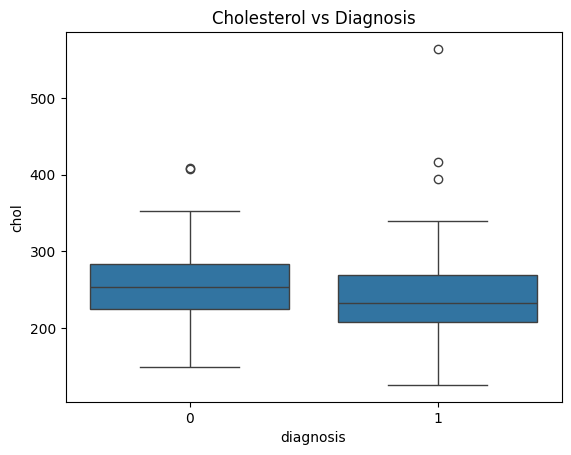

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=ha, x='diagnosis', y='chol')
plt.title('Cholesterol vs Diagnosis')
plt.show()

Doesn't make sense to have a negative cholesterol value, but based on the plot above, we can see that there isn't a clear/positive correlation between high cholesterol and getting diagnosized for disease.

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [27]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

intercept = lda.intercept_[0]
coef_age = lda.coef_[0][0]
coef_chol = lda.coef_[0][1]

cholesterol_needed = (0 - intercept - coef_age * age) / coef_chol
cholesterol_needed

368.23535752993797

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [28]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
svc = SVC(probability=True, kernel='linear')

grid_search = GridSearchCV(svc, param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [30]:
best_C = grid_search.best_params_['C']

svc_best = SVC(C=best_C, probability=True, kernel='linear')
svc_best.fit(X, y)

# The decision boundary is where the decision function equals zero
# w1 * age + w2 * chol + b = 0

coef_age = svc_best.coef_[0][0]
coef_chol = svc_best.coef_[0][1]
intercept = svc_best.intercept_[0]

cholesterol_needed = (-intercept - coef_age * age) / coef_chol
cholesterol_needed

312.7019396029427

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

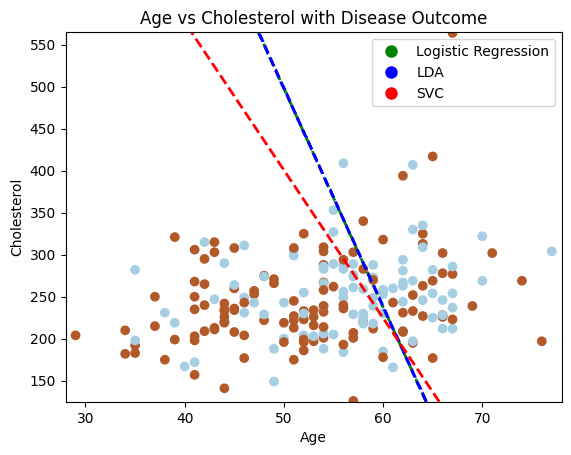

In [46]:
# Scatter plot of age vs cholesterol, coloring by true disease outcome (y)
plt.scatter(X["age"], X["chol"], c=y, cmap=plt.cm.Paired)
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Age vs Cholesterol with Disease Outcome')

# Create a mesh grid to evaluate the decision boundaries
x_min, x_max = X["age"].min() - 1, X["age"].max() + 1
y_min, y_max = X["chol"].min() - 1, X["chol"].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Create a DataFrame from the mesh grid
mesh_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=["age", "chol"])

# Logistic Regression Decision Boundary
Z_logreg = logreg.decision_function(mesh_data)  # Use decision_function instead of predict
Z_logreg = Z_logreg.reshape(xx.shape)
plt.contour(xx, yy, Z_logreg, levels=[0], colors='green', linewidths=2, linestyles='dashed')

# LDA Decision Boundary
Z_lda = lda.predict(mesh_data)
Z_lda = Z_lda.reshape(xx.shape)
plt.contour(xx, yy, Z_lda, levels=[0.5], colors='blue', linewidths=2, linestyles='dashed')

# SVC Decision Boundary
Z_svc = svc_best.decision_function(mesh_data)  # Same for SVC: decision_function can give you margin
Z_svc = Z_svc.reshape(xx.shape)
plt.contour(xx, yy, Z_svc, levels=[0], colors='red', linewidths=2, linestyles='dashed')

# Show the plot
logreg_patch = plt.Line2D([0], [0], marker='o', color='w', label='Logistic Regression',
                           markerfacecolor='green', markersize=10, linestyle='dashed')
lda_patch = plt.Line2D([0], [0], marker='o', color='w', label='LDA',
                       markerfacecolor='blue', markersize=10, linestyle='dashed')
svc_patch = plt.Line2D([0], [0], marker='o', color='w', label='SVC',
                        markerfacecolor='red', markersize=10, linestyle='dashed')

plt.legend(handles=[logreg_patch, lda_patch, svc_patch], loc='upper right')
plt.show()


The reason why the decision boundary for logistic model isn't showing might be because there are overlapping classes. Based on the plot in the first part(Logistic regression), we can see that the prediction for diagnosis are highly overlapping in terms of the two predictors, the model might find it difficult to separate them clearly resulted in a unclear decision boundary.